In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_json('train.json')

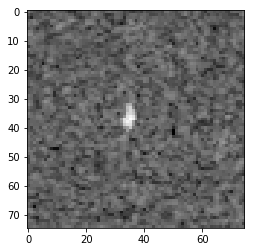

In [3]:
sample = np.reshape(train['band_2'][0], newshape=(75,75))

plt.imshow(sample,cmap='gray')

# Input Scope

In [24]:
tf.reset_default_graph()

height = 75
width = 75
n_inputs = height * width
channels = 1

with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name = 'X')
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.float32, shape=[None, 1], name = 'y')

# CNN

In [25]:
conv1_kernel = 7
conv1_fmaps = 64
conv1_stride = 1
conv1_padding = 'SAME'

conv2_kernel = 3
conv2_fmaps = 128
conv2_stride = 2
conv2_padding = 'SAME'

pool2_fmaps = conv2_fmaps



with tf.name_scope('CNN'):
    conv1 = tf.layers.conv2d(X_reshaped, filters = conv1_fmaps, name='conv1',
                         kernel_size = conv1_kernel, strides = conv1_stride,
                         padding = conv1_padding, activation=tf.nn.relu)
    pool1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], name='pool1',
                           strides=[1,2,2,1], padding = 'VALID')
    
    conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, name='conv2',
                            kernel_size=conv2_kernel, strides=conv2_stride,
                            padding=conv2_padding, activation=tf.nn.relu)
    pool2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], name='pool2',
                           strides=[1,2,2,1], padding = 'VALID')
    pool2_flat = tf.reshape(pool2, shape=[-1, pool2_fmaps * 3 * 3])

# Fully Connected Layers

In [26]:
fc1_units = 64
fc2_units = 32

n_outputs = 1

with tf.name_scope('fc'):
    fc1 = tf.layers.dense(pool2_flat, fc1_units, activation=tf.nn.relu, name='fc1')
    fc2 = tf.layers.dense(fc1, fc2_units, activation=tf.nn.relu, name='fc2')    

# Outputs

In [27]:
with tf.name_scope('output'):
    logits = tf.layers.dense(fc2, n_outputs, name='output')
    Y_proba = tf.nn.sigmoid(logits, name='Y_proba')

# Loss and Train

In [28]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

# Eval and utility

In [34]:
with tf.name_scope('eval'):
    correct = (logits > 0.5) == (y > 0.5)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope('util'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['band_1'], train['is_iceberg'], test_size = 0.2)

In [36]:
n_epochs = 10
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train)):
            X_batch = X_train[iteration*batch_size:iteration*batch_size +  batch_size]
            y_batch = y_train[iteration*batch_size:iteration*batch_size +  batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

ValueError: setting an array element with a sequence.

# Functions to save/restore the best parameters in RAM for early stopping

In [97]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

# Training with early stopping

In [121]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

Epoch 0, train accuracy: 98.0000%, valid. accuracy: 97.8600%, valid. best loss: 0.087491
Epoch 1, train accuracy: 94.0000%, valid. accuracy: 98.5400%, valid. best loss: 0.059195
Epoch 2, train accuracy: 100.0000%, valid. accuracy: 98.7600%, valid. best loss: 0.047129
Epoch 3, train accuracy: 100.0000%, valid. accuracy: 98.8600%, valid. best loss: 0.041908
Epoch 4, train accuracy: 98.0000%, valid. accuracy: 98.9800%, valid. best loss: 0.039140
Epoch 5, train accuracy: 100.0000%, valid. accuracy: 98.7000%, valid. best loss: 0.037097
Epoch 6, train accuracy: 100.0000%, valid. accuracy: 98.3000%, valid. best loss: 0.037097
Epoch 7, train accuracy: 100.0000%, valid. accuracy: 99.0800%, valid. best loss: 0.032768
Epoch 8, train accuracy: 100.0000%, valid. accuracy: 98.7400%, valid. best loss: 0.032768
Epoch 9, train accuracy: 100.0000%, valid. accuracy: 99.0600%, valid. best loss: 0.032768
Epoch 10, train accuracy: 100.0000%, valid. accuracy: 99.0200%, valid. best loss: 0.032768
Epoch 11, tr